In [1]:
!pip install -q transformers torch scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from torch.utils.data import Dataset

In [2]:
# uncomment to upload file to Colab
# from google.colab import files
# uploaded = files.upload()

In [3]:
# upload preprocessed_reviews.csv before running
df = pd.read_csv('preprocessed_reviews.csv')
df = df.dropna(subset=['cleaned_text', 'sentiment_binary', 'question_count'])
df['sentiment_binary'] = df['sentiment_binary'].astype(int)

# add question_count feature to text
df['text_with_features'] = df['cleaned_text'] + " questions: " + df['question_count'].astype(str)
print(f"loaded {len(df)} reviews")
df.head()

loaded 10381 reviews


,cleaned_text,sentiment_binary,has_upvotes,review_length,exclamation_count,question_count,ngram_great app,ngram_good app,ngram_easy use,ngram_love app,...,ngram_app easy use,ngram_buy pro version,ngram_using app years,ngram_paid pro version,ngram_really good app,ngram_simple easy use,ngram_used app years,ngram_sync google calendar,ngram_todo list app,text_with_features
0,cannot open app anymore,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,cannot open app anymore questions: 0
1,begging refund app month nobody replying,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,begging refund app month nobody replying quest...
2,costly premium version approx indian rupees pe...,0,0,21,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,costly premium version approx indian rupees pe...
3,used keep organized updates made mess things c...,0,0,23,6,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,used keep organized updates made mess things c...
4,dan birthday oct,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,dan birthday oct questions: 0


In [4]:
# 80/20 split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text_with_features'], df['sentiment_binary'],
    test_size=0.2, random_state=42
)
print(f"train: {len(train_texts)}, val: {len(val_texts)}")


train: 8304, val: 2077


In [5]:
# load pretrained bert model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# dataset class for bert tokenization
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.reset_index(drop=True)  # reset index after train/test split
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len  # bert max sequence length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])  # get text at index
        label = self.labels.iloc[idx]  # corresponding label

        # tokenize + encode text for bert
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,  # cut off text longer than max_len
            add_special_tokens=True,  # [CLS] and [SEP] tokens
            max_length=self.max_len,
            padding='max_length',  # pad shorter sequences
            return_attention_mask=True,  # tells bert which tokens to pay attention to
            return_tensors='pt'  # return pytorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),  # token ids
            'attention_mask': encoding['attention_mask'].flatten(),  # attention mask
            'labels': torch.tensor(label, dtype=torch.long)  # convert label to tensor
        }


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# create pytorch datasets for training
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# training configuration
training_args = TrainingArguments(
    output_dir='./bert_results',  #saved model checkpoints
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",  # accuracy used to determine best model
    report_to=None
)

# function to calculate metrics during evaluation
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)  # get predicted class
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions),
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions)
    }


In [ ]:
# setup trainer with early stopping (prevents overfitting)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]  # stop if no improvement for 1 epoch
)

print("training...")
start_time = time.time()

# train model
history = trainer.train()
training_time = time.time() - start_time


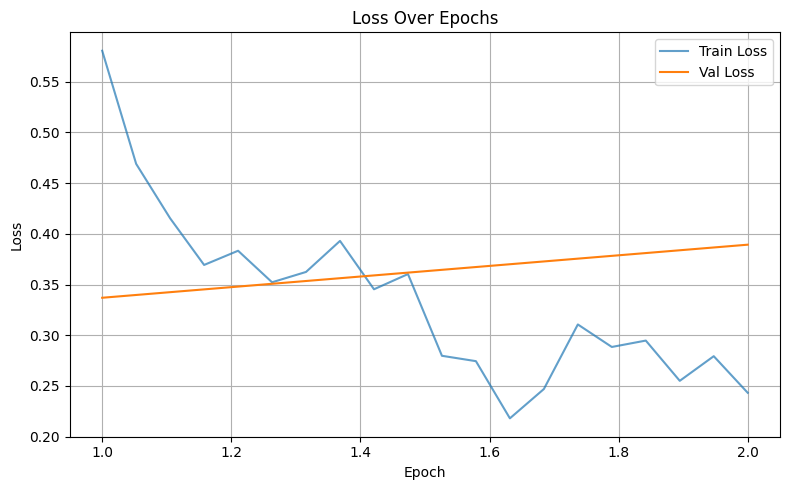

In [8]:
# get training history
log_history = trainer.state.log_history
train_losses = [log['loss'] for log in log_history if 'loss' in log]
val_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
val_accs = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]

# plot loss curves
epochs_list = range(1, len(val_losses) + 1)
plt.figure(figsize=(8, 5))

# plot training and validation loss
if train_losses:
    # spread training loss points across epochs for plotting
    train_epochs = np.linspace(1, len(val_losses), len(train_losses))
    plt.plot(train_epochs, train_losses, label='Train Loss', alpha=0.7)
plt.plot(epochs_list, val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
# get predictions on validation set using best model
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)  # convert probabilities to class predictions
y_true = val_labels.values  # actual labels

# calculate final metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


In [12]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Neg","Pos"],
    yticklabels=["Neg","Pos"]
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BERT Confusion Matrix')
plt.tight_layout()
plt.savefig("bert_confusion_matrix.png")
plt.close()


# save metrics to json file
metrics = {
    "model": "bert",
    "accuracy": acc,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "time": training_time
}

with open("bert_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

# save complete model and tokenizer
import os
os.makedirs("models", exist_ok=True)  # create models directory
model.save_pretrained("models/bert_sentiment")  # save model
tokenizer.save_pretrained("models/bert_sentiment")  # save tokenizer

print("model and metrics saved")

model and metrics saved


In [11]:
# Cell 10: Upload model to Drive
from google.colab import drive
drive.mount('/content/drive')

# Create zip file (easier to share)
!zip -r bert_model.zip models/bert_sentiment

# Upload to your personal Drive
!cp bert_model.zip /content/drive/MyDrive/

print("bert_model.zip uploaded to Drive")

Mounted at /content/drive
  adding: models/bert_sentiment/ (stored 0%)
  adding: models/bert_sentiment/special_tokens_map.json (deflated 42%)
  adding: models/bert_sentiment/tokenizer_config.json (deflated 75%)
  adding: models/bert_sentiment/model.safetensors (deflated 7%)
  adding: models/bert_sentiment/vocab.txt (deflated 53%)
  adding: models/bert_sentiment/config.json (deflated 49%)
bert_model.zip uploaded to Drive
